In [1]:
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

Instructions for updating:
Use the retry module or similar alternatives.


In [ ]:
#TODO:看一看加大index的影响

In [2]:
def elapsed(sec):
    if sec < 60:
        return "{:.2f}".format(sec) + " sec"
    elif sec < (60 * 60):
        return "{:.2f}".format(sec / 60) + " min"
    else:
        return "{:.2f}".format(sec / (60 * 60)) + " hr"

In [3]:
def showimg(img):
    plt.figure("Image")
    plt.imshow(img,cmap='gray')
    plt.axis('on')
    plt.title('image')
    plt.show()

In [4]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [5]:
HIDDEN_SIZE=128
INPUT_SIZE=787
INPUT_NUMBER=256
LAYER_NUMBER=4
INDEX_WEIGHT=1
is_training = tf.placeholder(tf.bool)

In [6]:
def make_layer(INPUT_SIZE,HIDDEN_SIZE,LAYER_NUMBER,is_training):
    x = tf.placeholder(tf.float32, [None, INPUT_SIZE],name='x')
    weights={'W0':tf.Variable(tf.truncated_normal([INPUT_SIZE, HIDDEN_SIZE], stddev=0.1))}
    bias={'b0':tf.Variable(tf.constant(0.1, shape=[HIDDEN_SIZE]))}
    a={'a0':tf.nn.tanh(tf.matmul(x, weights['W0']) + bias['b0'])}
    an={'an0':tf.layers.batch_normalization(a['a0'], training=is_training)}
    for i in range(1,LAYER_NUMBER+1):
        weights['W'+str(i)] = tf.Variable(tf.truncated_normal([HIDDEN_SIZE, HIDDEN_SIZE], stddev=0.1))
        bias['b' + str(i)] = tf.Variable(tf.constant(0.1, shape=[HIDDEN_SIZE]))
        a['a' + str(i)] = tf.nn.tanh(tf.matmul(an['an' + str(i-1)],weights['W'+str(i)]) + bias['b' + str(i)])
        an['an'+ str(i)]=tf.layers.batch_normalization(a['a' + str(i)], training=is_training)
    weights['W' + str(LAYER_NUMBER+1)] = tf.Variable(tf.truncated_normal([HIDDEN_SIZE, 784], stddev=0.1))
    bias['b' + str(LAYER_NUMBER+1)] = tf.Variable(tf.constant(0.1, shape=[784]))
    y = tf.nn.sigmoid(tf.matmul(an['an' + str(LAYER_NUMBER)],weights['W'+str(LAYER_NUMBER+1)])
                      + bias['b' + str(LAYER_NUMBER+1)])
    return x,y 
x,y=make_layer(INPUT_SIZE,HIDDEN_SIZE,LAYER_NUMBER,is_training)

In [7]:
def make_index(NUM,INPUT_SIZE):
    l=np.array([])
    for i in range(NUM):
        p=np.zeros((INPUT_SIZE))
        b=bin(i)[2:]
        _=len(b)-1
        for k in b:
            p[_]=k
            _-=1
        l=np.append(l,p)
    return l.reshape(-1,INPUT_SIZE)

In [8]:
global_step = tf.Variable(0)
learning_rate = tf.train.exponential_decay(0.0001,global_step,2000, 0.98, staircase=True) 

In [9]:
labels=tf.placeholder(tf.float32, [None, 784],name='labels')
loss=tf.losses.mean_squared_error(labels,y)
#loss=tf.reduce_mean(tf.losses.sigmoid_cross_entropy(labels,y))
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss,global_step=global_step)
    #GradientDescentOptimizer
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [10]:
def prepbatch(INPUT_NUMBER,INDEX_WEIGHT):
    batch_xs, batch_ys = mnist.train.next_batch(INPUT_NUMBER)
    inp=[]
    tran=[]
    ind=np.zeros(3)
    for i in range(len(batch_xs)):
        t_=batch_xs[i].reshape(28,28)
        t_=t_.reshape(-1)
        tran.append(t_)
        z=ind
        z[0]=INDEX_WEIGHT
        inp_=np.append(batch_xs[i],z)
        inp.append(inp_)
    for i in range(len(batch_xs)):
        t_=batch_xs[i][::-1].reshape(28,28)
        t_=t_.reshape(-1)
        tran.append(t_)
        z=ind
        z[1]=INDEX_WEIGHT
        inp_=np.append(batch_xs[i],z)
        inp.append(inp_)
    for i in range(len(batch_xs)):
        im=batch_xs[i].reshape(28,28)
        im_=np.zeros((im.shape[1],im.shape[0]))
        for j in range(im.shape[0]):
            im_[:,-j]=im[j]
        t_=im_
        t_=t_.reshape(-1)
        tran.append(t_)
        z=ind
        z[2]=INDEX_WEIGHT
        inp_=np.append(batch_xs[i],z)
        inp.append(inp_)
    inp=np.array(inp)
    tran=np.array(tran)
    return inp,tran


In [11]:
def showtrain(num,INDEX_WEIGHT):
    for j in range(num):
        print('TRAIN SET:')
        batch_xs,unuse=mnist.train.next_batch(1)
        newimg=batch_xs.reshape(-1)
        z=np.zeros(3)
        plt.subplot(231)
        plt.imshow(newimg.reshape(28,28),cmap='gray')
        k=z
        k[0]=INDEX_WEIGHT
        inpt=np.append(newimg,k).reshape(1,-1)
        oupt=sess.run(y,feed_dict={x:inpt,is_training:False})
        plt.subplot(234)
        plt.imshow(oupt.reshape(28,28),cmap='gray')
        newimg1=newimg[::-1].reshape(28,28)
        newimg1=newimg1.reshape(-1)
        plt.subplot(232)
        plt.imshow(newimg1.reshape(28,28),cmap='gray')
        k=z
        k[1]=INDEX_WEIGHT
        inpt=np.append(newimg,k).reshape(1,-1)
        oupt=sess.run(y,feed_dict={x:inpt,is_training:False})
        plt.subplot(235)
        plt.imshow(oupt.reshape(28,28),cmap='gray')
        im=newimg.reshape(28,28)
        im_=np.zeros((im.shape[1],im.shape[0]))
        for i in range(im.shape[0]):
            im_[:,-i]=im[i]
        plt.subplot(233)
        plt.imshow(im_.reshape(28,28),cmap='gray')
        k=z
        k[2]=INDEX_WEIGHT
        inpt=np.append(newimg,k).reshape(1,-1)
        oupt=sess.run(y,feed_dict={x:inpt,is_training:False})
        plt.subplot(236)
        plt.imshow(oupt.reshape(28,28),cmap='gray')
        plt.show()
def showtest(num,INDEX_WEIGHT):
    print('TEST SET:')
    for j in range(num):
        newimg,lb=mnist.test.next_batch(1)
        newimg=newimg.reshape(-1)
        z=np.zeros(3)
        #print('GROUND TRUTH1:')
        #showimg(newimg.reshape(28,28))
        plt.subplot(231)
        plt.imshow(newimg.reshape(28,28),cmap='gray')
        #print('TRANS1:')
        k=z
        k[0]=INDEX_WEIGHT
        inpt=np.append(newimg,k).reshape(1,-1)
        oupt=sess.run(y,feed_dict={x:inpt,is_training:False})
        plt.subplot(234)
        plt.imshow(oupt.reshape(28,28),cmap='gray')
        #showimg(oupt.reshape(28,28))
        #print('GROUND TRUTH2:')
        newimg1=newimg[::-1].reshape(28,28)
        newimg1=newimg1.reshape(-1)
        #showimg(newimg1.reshape(28,28))
        plt.subplot(232)
        plt.imshow(newimg1.reshape(28,28),cmap='gray')
        #print('TRANS2:')
        k=z
        k[1]=INDEX_WEIGHT
        inpt=np.append(newimg,k).reshape(1,-1)
        oupt=sess.run(y,feed_dict={x:inpt,is_training:False})
        #showimg(oupt.reshape(28,28))
        plt.subplot(235)
        plt.imshow(oupt.reshape(28,28),cmap='gray')
        #print('GROUND TRUTH3:')
        im=newimg.reshape(28,28)
        im_=np.zeros((im.shape[1],im.shape[0]))
        for i in range(im.shape[0]):
            im_[:,-i]=im[i]
        #showimg(im_)
        plt.subplot(233)
        plt.imshow(im_.reshape(28,28),cmap='gray')
        #print('TRANS3:')
        k=z
        k[2]=INDEX_WEIGHT
        inpt=np.append(newimg,k).reshape(1,-1)
        oupt=sess.run(y,feed_dict={x:inpt,is_training:False})
        #showimg(oupt.reshape(28,28))
        plt.subplot(236)
        plt.imshow(oupt.reshape(28,28),cmap='gray')
        plt.show()

0.57296723
TRAIN SET:


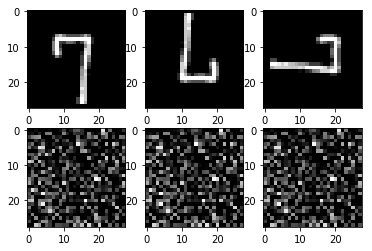

TRAIN SET:


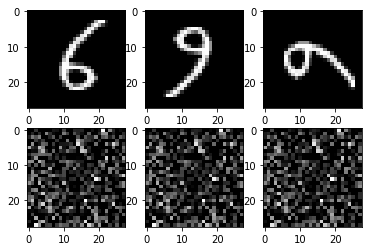

TEST SET:


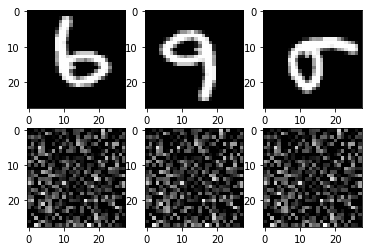

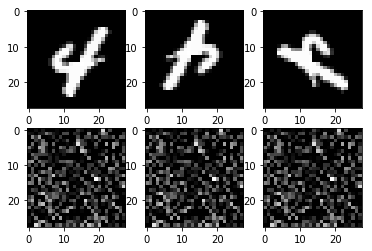

TPI:0.052158756732940674sec
0.06831326
0.059660133
0.050022565
0.0392796
0.028845787
TRAIN SET:


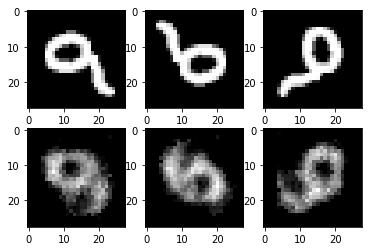

TRAIN SET:


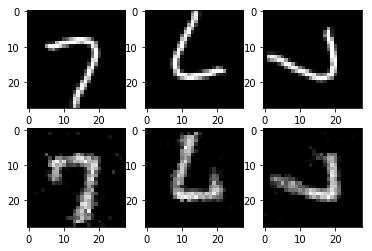

TEST SET:


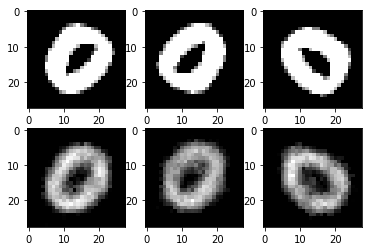

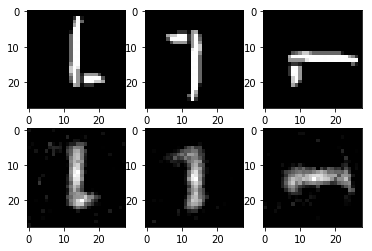

0.023739781
0.019026665
0.01683778
0.016180104
0.014037012
TRAIN SET:


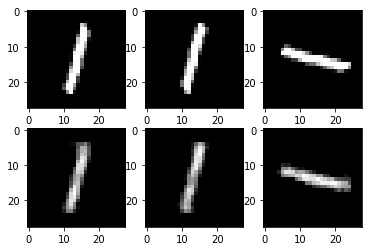

TRAIN SET:


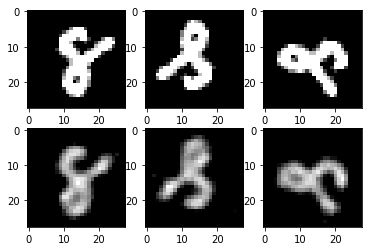

TEST SET:


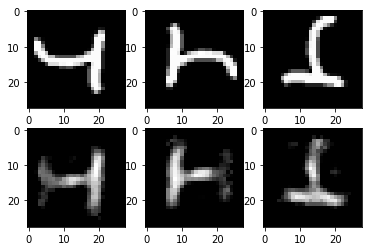

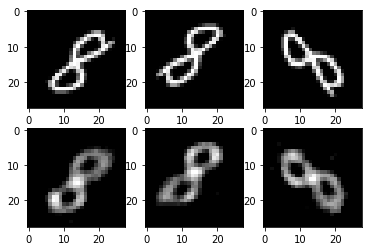

0.013557775
0.013036719
0.012194352
0.011556804
0.011199288
TRAIN SET:


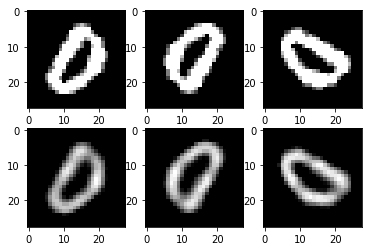

TRAIN SET:


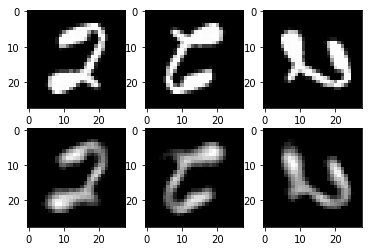

TEST SET:


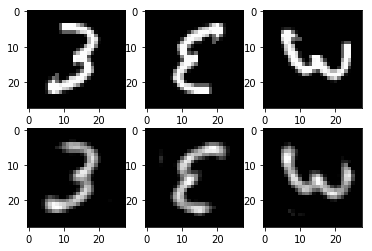

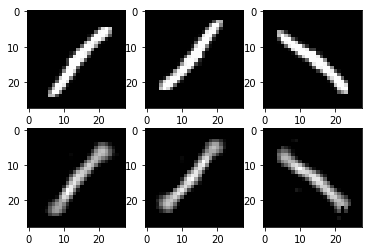

0.01083599
0.010423052
0.010231009
0.01047437
0.009287818
TRAIN SET:


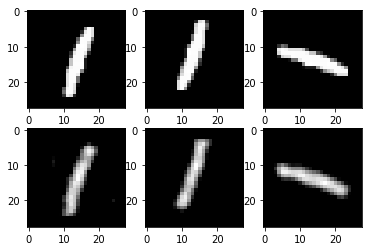

TRAIN SET:


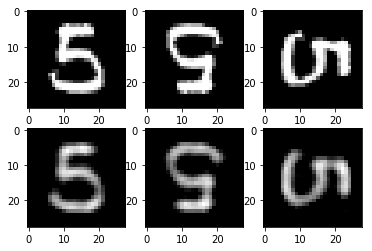

TEST SET:


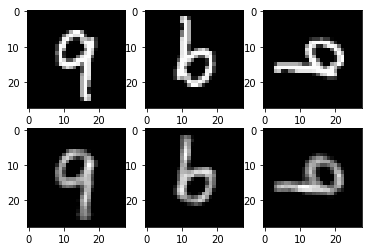

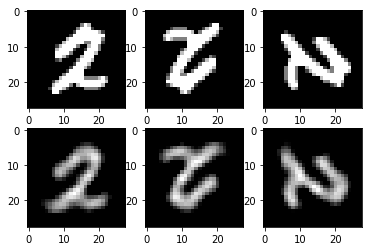

0.009778832
0.009808845
0.009242776
0.009237476


KeyboardInterrupt: 

In [12]:
cost=1
i=0
start_time=time.time()
while cost>0.000001:
    inp,tran=prepbatch(INPUT_NUMBER,INDEX_WEIGHT)
    unuse,cost=sess.run([train_step,loss],feed_dict={x:inp,labels:tran,is_training:True})
    if i % 1000==0:
        print(cost)
    if i==500:
        tpi=(time.time() - start_time)/500
        print('TPI:'+str(tpi)+'sec')
    if i%5000==0:
        showtrain(2,INDEX_WEIGHT)
        showtest(2,INDEX_WEIGHT)

    i+=1
print('ITERATION:'+str(i))
print("Elapsed time: ", elapsed(time.time() - start_time))

In [ ]:
showtrain(5,INDEX_WEIGHT)
showtest(5,INDEX_WEIGHT)